![](https://i.imgur.com/eBRPvWB.png)

# Practical PyTorch: Generating Shakespeare with a Character-Level RNN

[In the RNN classification tutorial](https://github.com/spro/practical-pytorch/blob/master/char-rnn-classification/char-rnn-classification.ipynb) we used a RNN to classify text one character at a time. This time we'll generate text one character at a time.

```
> python generate.py -n 500

PAOLTREDN:
Let, yil exter shis owrach we so sain, fleas,
Be wast the shall deas, puty sonse my sheete.

BAUFIO:
Sirh carrow out with the knonuot my comest sifard queences
O all a man unterd.

PROMENSJO:
Ay, I to Heron, I sack, againous; bepear, Butch,
An as shalp will of that seal think.

NUKINUS:
And house it to thee word off hee:
And thou charrota the son hange of that shall denthand
For the say hor you are of I folles muth me?
```

This one might make you question the series title &mdash; "is that really practical?" However, these sorts of generative models form the basis of machine translation, image captioning, question answering and more. See the [Sequence to Sequence Translation tutorial](https://github.com/spro/practical-pytorch/blob/master/seq2seq-translation/seq2seq-translation.ipynb) for more on that topic.

# Recommended Reading

I assume you have at least installed PyTorch, know Python, and understand Tensors:

* http://pytorch.org/ For installation instructions
* [Deep Learning with PyTorch: A 60-minute Blitz](https://github.com/pytorch/tutorials/blob/master/Deep%20Learning%20with%20PyTorch.ipynb) to get started with PyTorch in general
* [jcjohnson's PyTorch examples](https://github.com/jcjohnson/pytorch-examples) for an in depth overview
* [Introduction to PyTorch for former Torchies](https://github.com/pytorch/tutorials/blob/master/Introduction%20to%20PyTorch%20for%20former%20Torchies.ipynb) if you are former Lua Torch user

It would also be useful to know about RNNs and how they work:

* [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) shows a bunch of real life examples
* [Understanding LSTM Networks](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) is about LSTMs specifically but also informative about RNNs in general

Also see these related tutorials from the series:

* [Classifying Names with a Character-Level RNN](https://github.com/spro/practical-pytorch/blob/master/char-rnn-classification/char-rnn-classification.ipynb) uses an RNN for classification
* [Generating Names with a Conditional Character-Level RNN](https://github.com/spro/practical-pytorch/blob/master/conditional-char-rnn/conditional-char-rnn.ipynb) builds on this model to add a category as input

# Prepare data

The file we are using is a plain text file. We turn any potential unicode characters into plain ASCII by using the `unidecode` package (which you can install via `pip` or `conda`).

In [145]:
!pip install unidecode

In [146]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import unidecode
import string
import random
import re
import numpy as np

all_characters = string.printable
n_characters = len(all_characters)


file = unidecode.unidecode(open('data/speeches.txt').read())
#file = unidecode.unidecode(open('drive/My Drive/Colab Notebooks/speeches.txt').read())
file = re.sub("SPEECH\s+\d+", "", file)  # Remove the speech headers
file = re.sub("\n+", "\n", file)
file = re.sub("\d+\\\d+\\\d+", "", file)  # Remove the dates
file = re.sub(" +", " ", file)
file =' '.join(file.splitlines())
file_len = len(file)
print('file_len =', file_len)

file_len = 893170


To make inputs out of this big string of data, we will be splitting it into chunks.

In [6]:
chunk_len = 200

def random_chunk():
    start_index = random.randint(0, file_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return file[start_index:end_index]

print(random_chunk())


 said that Brexit's going to happen. I said that they are going to break away. And everybody laughed at me. And the odds were 20 percent. And then when it happened, she took an ad saying, oh, Donald Tr


Creating similar validation set

In [149]:
similar_val_set = []
val_start_index = 5000
for i in range(200):
    val_end_index = val_start_index + chunk_len + 1
    similar_val_set.append(file[val_start_index:val_end_index])
    val_start_index = val_end_index
print(similar_val_set[0])

 why aren't our politicians finding out where those e-mails are? They talk about executive orders and they talk about immigration and they talk about oh well we have to stop the border; that's the end 


Creating different validation set

In [7]:
diff_val_set = []
# with open('drive/My Drive/Colab Notebooks/jane_austen.txt',encoding='utf-8',errors='ignore') as f:
#     file_2 = f.read()


with open('data/jane_austen.txt',encoding='utf-8',errors='ignore') as f:
    file_2 = f.read()

val_start_index = 20000
for i in range(200):
    val_end_index = val_start_index + chunk_len + 1
    diff_val_set.append(file_2[val_start_index:val_end_index])
    val_start_index = val_end_index
print(diff_val_set[0])

father to be
proceeding, his friends to be urging him.  She considered it as an act
of indispensable duty to clear away the claims of creditors with all
the expedition which the most comprehensive retr


# Build the Model

This model will take as input the character for step $t_{-1}$ and is expected to output the next character $t$. There are three layers - one linear layer that encodes the input character into an internal state, one GRU layer (which may itself have multiple layers) that operates on that internal state and a hidden state, and a decoder layer that outputs the probability distribution.

In [0]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

# Inputs and Targets

Each chunk will be turned into a tensor, specifically a `LongTensor` (used for integer values), by looping through the characters of the string and looking up the index of each character in `all_characters`.

In [152]:
# Turn string into list of longs
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return Variable(tensor)

print(char_tensor('abcDEF'))

tensor([10, 11, 12, 39, 40, 41])


Finally we can assemble a pair of input and target tensors for training, from a random chunk. The input will be all characters *up to the last*, and the target will be all characters *from the first*. So if our chunk is "abc" the input will correspond to "ab" while the target is "bc".

In [0]:
def random_training_set():    
    chunk = random_chunk()
    inp = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
    return inp, target

# Evaluating

To evaluate the network we will feed one character at a time, use the outputs of the network as a probability distribution for the next character, and repeat. To start generation we pass a priming string to start building up the hidden state, from which we then generate one character at a time.

In [0]:
def evaluate(prime_str='A', predict_len=100, temperature=0.8):
    hidden = decoder.init_hidden()
    prime_input = char_tensor(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[p], hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char_tensor(predicted_char)

    return predicted

# Training

A helper to print the amount of time passed:

In [0]:
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

The main training function

In [0]:
def train(inp, target):
    hidden = decoder.init_hidden()
    decoder.zero_grad()
    loss = 0
    #print(inp,target)
    for c in range(chunk_len):
        output, hidden = decoder(inp[c], hidden)
        loss += criterion(output, target[c].unsqueeze(0))

    loss.backward()
    decoder_optimizer.step()

    return loss.data.item() / chunk_len

In [0]:
# generally when we calculate perplexity by taking exponent of the loss ,but in this character level rnn ,we are not going to take exponents of every character rather averaging 
# them out and then averaging out over the chunks
def get_perplexity(validation_set):
    p = 0
    for chunk in validation_set:
        hidden = decoder.init_hidden()
        chunk_loss = 0
        inp = char_tensor(chunk[:-1])
        target = char_tensor(chunk[1:])
        for c in range(chunk_len):  
            output, hidden = decoder(inp[c], hidden)
            chunk_loss += criterion(output, target[c].unsqueeze(0))
        p = p + np.exp((chunk_loss/chunk_len).data.item())
    avg_perplexity = p/len(validation_set)
    return avg_perplexity

Then we define the training parameters, instantiate the model, and start training:

In [158]:
n_epochs = 2000
print_every = 100
plot_every = 10
hidden_size = 100
n_layers = 1
lr = 0.002

decoder = RNN(n_characters, hidden_size, n_characters, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    loss = train(*random_training_set())       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print("Perplexity : " + str(get_perplexity(similar_val_set)))
        print(evaluate('Wh', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

 13s (100 5%) 2.3425]
Perplexity : 11.192438511535299
Whe. wedls, rer W. I Tiny gore din goabilc thing thacaithig the ary a ogtianke thaiy sant taut the the 

 39s (200 10%) 2.2341]
Perplexity : 9.550013886515126
Whs go menatell. Oon ow, the us hat wat. I they wiveoll to a secthery. Thingid way didaingopent to gor 

 4s (300 15%) 1.9608]
Perplexity : 8.435203606575298
Wh}enting zake and betrss. The taon fere then more as sing bl. I gothead thom yol. We coip. We kessino 

 31s (400 20%) 1.9826]
Perplexity : 7.803039320414591
Wh. Iv't dighs ther'm to so with evencaus. I And doodd wact wo wit that kat that out koud have ring th 

 57s (500 25%) 1.7678]
Perplexity : 7.385696775531398
Wh. We do mesple sore preople becon allit. ne- memould plenisusser of to be conbal. And Amen. So cout  

 23s (600 30%) 1.4868]
Perplexity : 6.907227423328348
Wh don't sorly monery and in the's a people inth we monow say the whorly int hill concry up.S.. I me w 

 49s (700 35%) 2.0547]
Perplexity : 6.773999267

# Plotting the Training Losses

Plotting the historical loss from all_losses shows the network learning:

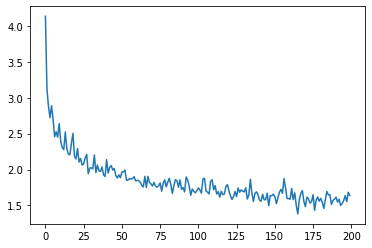

In [159]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

# Comparing perplexities for similar and different validation sets

In [160]:
print("Similar dataset perplexity : " + str(get_perplexity(similar_val_set)))
print("Different dataset perplexity : " + str(get_perplexity(diff_val_set)))

Similar dataset perplexity : 5.412911452077031
Different dataset perplexity : 11.023044967539768


# Evaluating at different "temperatures"

In the `evaluate` function above, every time a prediction is made the outputs are divided by the "temperature" argument passed. Using a higher number makes all actions more equally likely, and thus gives us "more random" outputs. Using a lower value (less than 1) makes high probabilities contribute more. As we turn the temperature towards zero we are choosing only the most likely outputs.

We can see the effects of this by adjusting the `temperature` argument.

In [164]:
print(evaluate('Th', 200, temperature=0.6))

The have to do it to it workes like the have to every note. It's because the protion at like they don't let all of the can't let it for every one of the say they are that big me the done, the would the 


Lower temperatures are less varied, choosing only the more probable outputs:

In [162]:
print(evaluate('Th', 200, temperature=0.2))

The people the said I said "Well and the come and the some of the come of the come of the for the country it the been the better the can and the better the come it the be the better the so be a lot the 


Higher temperatures more varied, choosing less probable outputs:

In [163]:
print(evaluate('Th', 200, temperature=1.4))

Thesafleal fight -ore for makevoned, whocle conney's use Pact if bin, the wel rid leat. Ss whose vet a preage's nyid, get's gest a fabuaugh, Maxffof one in a. I veh mirst rime Diggy. Flino, it Mun(ppre 


# Exercises

* Train with your own dataset, e.g.
    * Text from another author
    * Blog posts
    * Code
* Increase number of layers and network size to get better results

**Next**: [Generating Names with a Conditional Character-Level RNN](https://github.com/spro/practical-pytorch/blob/master/conditional-char-rnn/conditional-char-rnn.ipynb)